## Load Libraries

In [1]:
import pandas as pd 
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
import networkx as nx
import sys
import random

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import DistanceMetric
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from matplotlib import rcParams, cycler

## Declare Functions

In [31]:
def norm_and_pca_from_df(df):
    '''
    Function processes the data using Principal component analysis(PCA)
    Args:
        df : Dataframe 
    Returns dataframe containing rincipal component of df
    '''
    
    df_normalized = pd.DataFrame()
    cols = list(df.columns)
    df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
    
    df_pca = pd.DataFrame(PCA(n_components = 3).fit_transform(df_normalized))
    df_pca.columns = ['P1', 'P2', 'P3']
    df_pca.index = df.index
    
    return df_normalized, df_pca

########################################################################################

def get_graph(df, proximity_measure) :
    '''
    Function to create graph
    Args:
        df: Dataframe
        proximity_measure = Distance measure
    Returns graph of df
    '''
    dist = DistanceMetric.get_metric(proximity_measure)
    matrix_dist = dist.pairwise(df.to_numpy())
    graph = nx.from_numpy_matrix(matrix_dist)
    
    return graph

##########################################################################################

def calculate_eigen_NJW(df, proximity_measure, sigma, k):
    '''
    Function to get eigenvalues and eigenvectors using equation proposed by NJW algorithm
    Args:
        df: Dataframe
        sigma: local scaling parameter
        proximity_measure = distance measures
        k = number of clusters
    Returns matrices containing adjacency and degree values
    '''
    dimension = df.shape[0]
    
    adjacency_matrix = np.zeros([dimension, dimension])
    
    dist = iter(pdist(df, metric=proximity_measure))

    for i in range(dimension):
        for j in range(i+1, dimension):
            d = np.exp(-1 * next(dist)**2/(2 * sigma ** 2))
            adjacency_matrix[i,j] = d
            adjacency_matrix[j,i] = d
            
    
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    
    # Normalized laplacian matrix
    d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
    laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)
    
    e, v = np.linalg.eigh(laplacian_matrix_normalized)
    X = v[:, -1*k:]
    
    row_sums = X.sum(axis=1)
    Y = X / row_sums[:, np.newaxis]
            
    return X, Y

###########################################################################################

# def calculate_eigen(degree_matrix,adjacency_matrix, k):
#     '''
#     Function to get degree matrix and normalized laplacian matrix
#     Args:
#         degree_matrix : matrix containing degree of each point
#         adjacency_matrix: adjacency matrix of the input data. 
#     Returns normalized Laplacian matrix 
#     '''
    
#     # laplacian_matrix = degree_matrix - adjacency_matrix
    
#     # Normalized laplacian matrix
#     d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
#     laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)
    
#     e, v = np.linalg.eigh(laplacian_matrix_normalized)
#     X = v[:, -1*k:]
    
#     row_sums = X.sum(axis=1)
#     Y = X / row_sums[:, np.newaxis]
    
#     return X, Y

############################################################################################

def cluster_plots(df_pca_labelled, data, algorithm, k):
    
    if algorithm == OPTICS:
        df_pca_labelled['cluster'] = algorithm(min_samples=k).fit_predict(data)
        
    else:
        df_pca_labelled['cluster'] = algorithm(n_clusters=k).fit_predict(data)
    
    rcParams['figure.figsize']= 12,4

    plt.subplot(1,3,1)
    plot1a = sns.scatterplot(data=df_pca_labelled, x="P1", y="P2", hue="class_label", palette="tab10", s=80, legend=False)
    plot1a.set_title('class labels')

    plt.subplot(1,3,2)
    plot1b = sns.scatterplot(data=df_pca_labelled, x="P1", y="P2", hue="cluster", palette="tab10", s=80, legend=False)
    plot1b.set_title('cluster labels')

    matrix = confusion_matrix(df_pca_labelled.class_label, df_pca_labelled.cluster)
    plt.subplot(1,3,3)
    plot2 = sns.heatmap(matrix, annot=True, cmap="tab10")
    plot2.set(xlabel='Clustering Label', ylabel='Class Label')

    plt.tight_layout()

## Dataset 1

In [32]:
## Load dataset 1
df_csv = pd.read_csv("dataset_1/mp_samples.csv")
# df_graph = pd.read_csv("dataset_1/graph.csv")
df_csv.index = df_csv.Patients
df_csv_data = df_csv.iloc[:, 2:2971]
df_csv_data2 = df_csv_data.loc[:,(df_csv_data.mean() >= 300)]
df_csv_data2.shape

df_normalized, df_pca = norm_and_pca_from_df(df_csv_data)

df_pca['class_label'] = ['CD' if 'CD' in index else 'UC' if 'UC' in index else 'C' for index, patient in df_pca.iterrows()]
df_pca['class_label'] = df_pca['class_label'].astype('category').cat.codes

df_pca_control = df_pca[['P1','P2','P3']]

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_8024\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usua

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[cols] = pd.DataFrame(normalize(StandardScaler().fit_transform(df[cols])))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is u

1


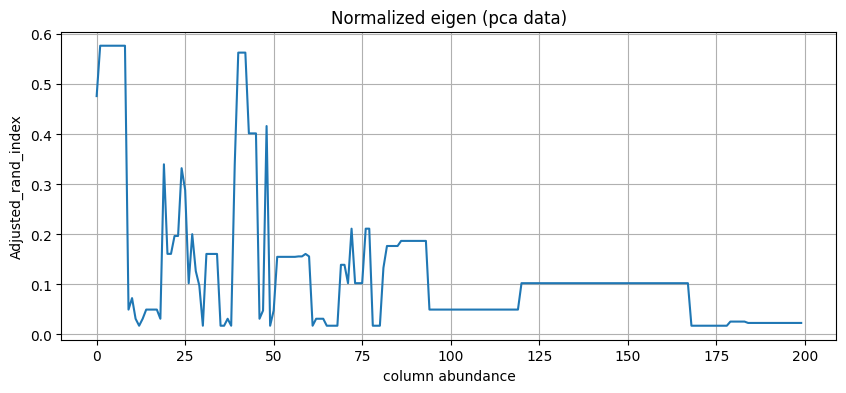

In [117]:
## Find optimal sigma for abundant columns
abund_vals = []
rand_vals = []

for abundance in range(0, 200):
    
    df_temp = df_csv_data.loc[:,(df_csv_data.mean() >= abundance)]
    df_temp_norm, df_temp_pca = norm_and_pca_from_df(df_temp)
    
    try:
        X,Y = calculate_eigen_NJW(df_temp_norm, 'braycurtis', 0.25, 3)
        clustering = KMeans(n_clusters = 3)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(Y)
        abund_vals.append(abundance)
        rand_vals.append(adjusted_rand_score(df_pca.class_label, clustering.labels_))
        
    except:
        pass
    
    
thisdict = dict(zip(abund_vals,rand_vals))
opt_val = max(thisdict, key = (lambda k: thisdict[k]))

print(opt_val)
    
rcParams['figure.figsize']= 10,4
plt.plot(abund_vals, rand_vals)
plt.xlabel('column abundance')
plt.ylabel('Adjusted_rand_index')
plt.title('Normalized eigen (pca data)')
plt.grid()
plt.show()

C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.exp(-1 * next(dist)**2/(2 * sigma ** 2))
C:\Users\49171\AppData\Local\Temp\ipykernel_17356\2416993017.py:70: RuntimeWarning: invalid value encountered in divide
  Y = X / row_sums[:, np.newaxis]


0.2


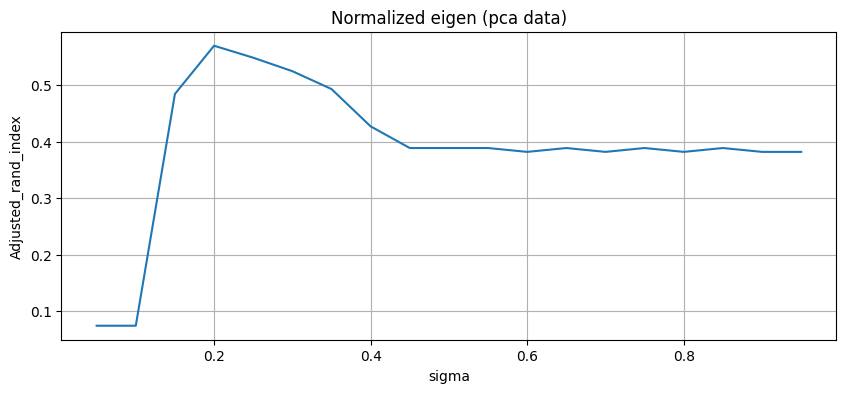

In [102]:
## Find optimal sigma

sigma_vals = []
rand_vals = []

for sigma in np.arange(0, 1, 0.05):
    
    try:
        X,Y = calculate_eigen_NJW(df_csv_data, 'braycurtis', sigma, 3)
        clustering = KMeans(n_clusters = 3)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(X)
        sigma_vals.append(sigma)
        rand_vals.append(adjusted_rand_score(df_pca.class_label, clustering.labels_))
        
    except:
        pass
    
    
thisdict = dict(zip(sigma_vals,rand_vals))
opt_val = max(thisdict, key = (lambda k: thisdict[k]))

print(opt_val)
    
rcParams['figure.figsize']= 10,4
plt.plot(sigma_vals, rand_vals)
plt.xlabel('sigma')
plt.ylabel('Adjusted_rand_index')
plt.title('Normalized eigen (pca data)')
plt.grid()
plt.show()
    

In [27]:
# Normalized and unnormalized eigenvalues and vectors
X,Y = calculate_eigen_NJW(df_pca_control, 'euclidean', 0.35, 3)
df_U = pd.DataFrame(X)
df_N = pd.DataFrame(Y)

In [28]:
X,Y = calculate_eigen_NJW(df_pca_control, 'euclidean', 0.2, 3)
df_N = pd.DataFrame(Y)

## Dataset 2

In [ ]:
# Load dataset 2
df_csv = pd.read_csv("dataset_2/mp_clustering.csv")
df_csv.rename(columns={"Metaprotein": "Patients"})
df_csv.index = df_csv.Patients
df_csv_data = df_csv.iloc[:, 1:1753]
df_csv_data2 = df_csv_data.loc[:,(df_csv_data.mean() >= 200)]
df_csv_data2.shape

df_normalized, df_pca = norm_and_pca_from_df(df_csv_data)

df_pca['class_label'] = ['CD' if 'CD' in index else 'IBS' if 'IBS' in  index  
                         else 'CD_IBS' if 'P28_CD_IBS' in index else 'UCr' if 'UCr' in index 
                         else 'UCa' if 'UCa' in index else 'IBS' if 'IBS' in index 
                         else 'GCA' if 'GCA' in index else 'A' if 'C' not in index else 'C' 
                         for index, patient in df_pca.iterrows()]
df_pca['class_label'] = df_pca['class_label'].astype('category').cat.codes

df_pca_control = df_pca[['P1','P2']]

In [ ]:
# Normalized Eigen values and vectors
adj_mat, deg_mat = adjacency_and_degree_matrix_NJW(df_csv_data, 120, 'euclidean' )
X,Y = calculate_eigen(deg_mat, adj_mat, 3)
df_U = pd.DataFrame(X)
df_N = pd.DataFrame(Y)

## Plot silhouette to find optimal k

 Original 
 data (optimal value, highest silhouette): (3, 0.326298427080316)
 Normalized (optimal value, highest silhouette): (3, 0.13854994301563692)
 PCA (optimal value, highest silhouette): (3, 0.2244039311781878)
 Original 
 data (optimal value, highest adjusted rand): (3, 0.18210638235609702)
 Normalized (optimal value, highest adjusted rand): (3, 0.5282663172923929)
 PCA (optimal value, highest adjusted rand): (3, 0.5302481300887655)


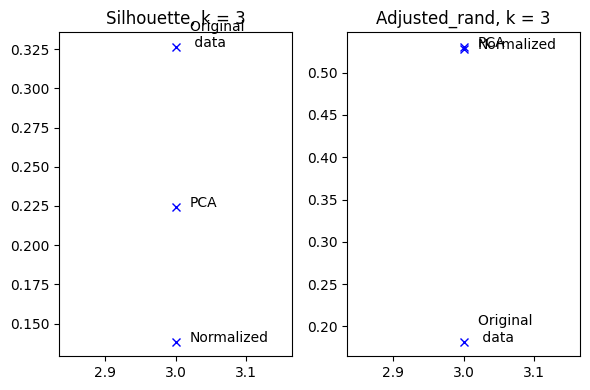

In [33]:
range_param = [3]
algorithms = [KMeans]
df_csv_data.name = 'Original \n data'
df_csv_data2.name = 'Abundant \n columns'
df_normalized.name = 'Normalized'
df_pca_control.name = 'PCA'
df_U.name = 'Unnorm. eigen'
df_N.name = 'Norm. eigen'

list_df = [df_csv_data, df_normalized, df_pca_control]

rcParams['figure.figsize']= 6,4

random.seed(10)

plt.subplot(1,2,1)
for df in list_df:
    
    df_temp = df
    
    silhouette_values = []
        
    for value in range_param:
        clustering = AgglomerativeClustering(n_clusters = value)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(df)
        cluster_labels = clustering.labels_  
        silhouette_values.append(silhouette_score(df_csv_data, cluster_labels))

    thisdict = dict(zip(range_param,silhouette_values))
    opt_val = max(thisdict, key = (lambda k: thisdict[k]))
    print(f' {df.name} (optimal value, highest silhouette): {opt_val, thisdict[opt_val]}')
    plt.plot(range_param,silhouette_values,'-bx')
    plt.annotate(f'{df.name}', xy = (opt_val + 0.02, thisdict[opt_val]))
    plt.title(f'Silhouette, k = {range_param[0]}')
    
    
plt.subplot(1,2,2)
for df in list_df:
    
    df_temp = df
    
    adjusted_rand_values = []
        
    for value in range_param:
        clustering = AgglomerativeClustering(n_clusters = value)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(df)
        cluster_labels = clustering.labels_  
        adjusted_rand_values.append(adjusted_rand_score(df_pca.class_label, cluster_labels))

    thisdict = dict(zip(range_param,adjusted_rand_values))
    opt_val = max(thisdict, key = (lambda k: thisdict[k]))
    print(f' {df.name} (optimal value, highest adjusted rand): {opt_val, thisdict[opt_val]}')
    plt.plot(range_param,adjusted_rand_values,'-bx')
    plt.annotate(f'{df.name}', xy = (opt_val + 0.02, thisdict[opt_val]))
    plt.title(f'Adjusted_rand, k = {range_param[0]}')
    
plt.tight_layout()
plt.show()

## Class labels vs Cluster Visualization

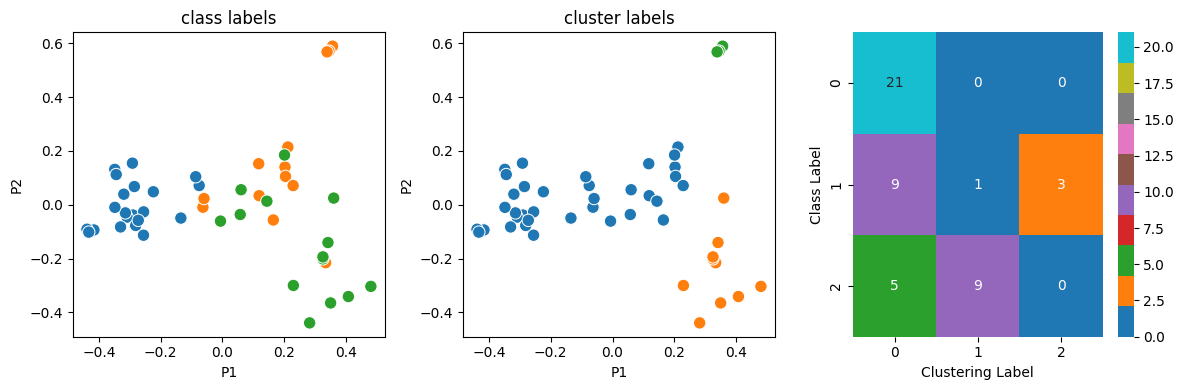

In [82]:
cluster_plots(df_pca, df_pca_control, SpectralClustering, 3)

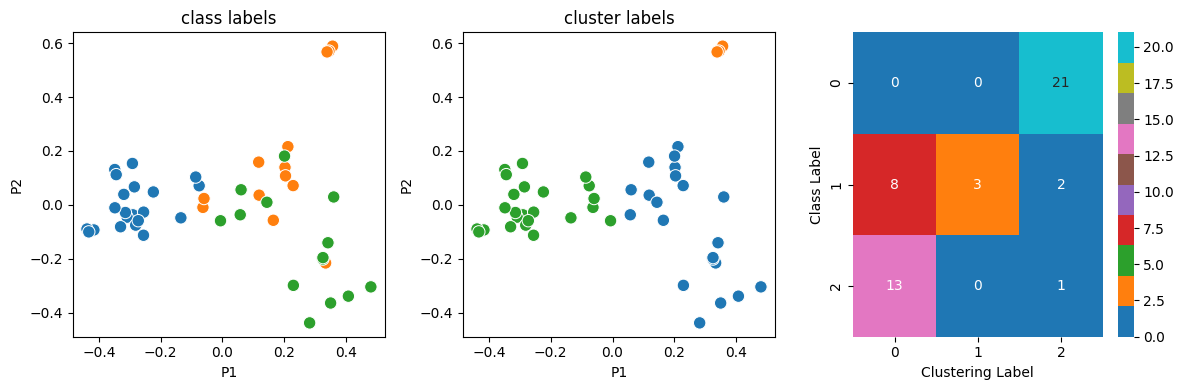

In [106]:
cluster_plots(df_pca, df_U, KMeans, 3)

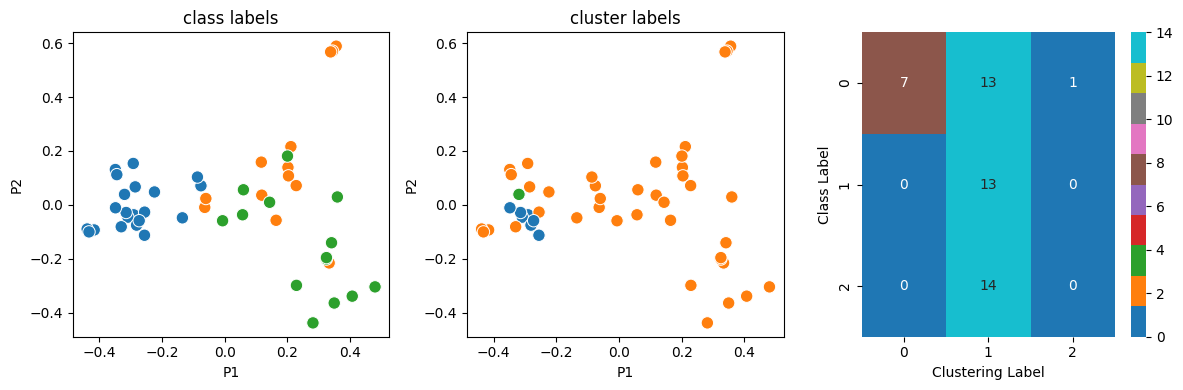

In [107]:
cluster_plots(df_pca, df_N, KMeans, 3)

In [108]:
df_U

,0,1,2
0,0.010643,0.019142,-0.160466
1,0.171853,0.022541,-0.174182
2,0.157456,0.020046,-0.154534
3,0.173691,0.022644,-0.174807
4,0.172612,0.020577,-0.157684
5,0.165097,0.018476,-0.140740
6,0.155554,0.017061,-0.129728
7,0.155198,0.017017,-0.129390
8,0.044066,0.011165,-0.088772
9,0.051485,0.011449,-0.090453
